In [17]:
import numpy as np

# Feed forward

## Data Matrices

For the fully connected feed forward neural network, we have multiple important matrices to keep track of. Let's first define the data matrices for the undefined supervised learning problem that our network will be training on. 

$$X = \begin{bmatrix}
    x_{1,1} & \cdots & x_{1,m} \\
    \vdots & \ddots & \vdots \\
    x_{n_x,1} & \cdots & x_{n_x,m}
\end{bmatrix}$$

Here, $n_x$ is the number of features in the input dataset. $m$ is the number of training examples we will feed into the network. So $X$ can be thought of a collection of column vectors where each one represents a datapoint.

$\underline{Y}$ is defined similarly, where this is the matrix that contains the labels for the training data. 

$$\underline{Y} = \begin{bmatrix}
    y_1 & \cdots & y_i \cdots & y_m
\end{bmatrix}$$

$y_i$ is intentionally left ambiguous here, as it will vary depending on the problem. If it is regression or binary classification, it will be a number, if it is multiclass classification, it will be a vector.

In [18]:
# For now, invent meaningless data that is already normalised for development.
X = np.random.randn(10, 1000) # 100 features, 1000 examples
Y = np.random.randint(2, size=(1,1000)) # the training labels for binary classification for 1000 examples
nx = X.shape[0]
m = X.shape[1]
ny = Y.shape[0]
print("The number of features are ", nx)
print("The number of training examples are ", m)

The number of features are  10
The number of training examples are  1000


## Layer Matrices

### Layer 1

The transformations of the data at each layer are defined by a weight and a bias matrix. These define the sum of linear regressions that are happening at each layer in each neuron in the network. 

For the first hidden layer, the feature matrix $X$ undergoes the linear transformation 

$$Z^{[1]} = W^{[1]}X + B^{[1]}$$

where $W^{[1]}X$ is the weight matrix of the first layer of dimension $(n_{h}^{[1]}, n_x)$ where $n_{h}^{[1]}$ is the number of neurons in the first hidden layer. This ensures that the product $W^{[1]}X$ has the dimension $(n_{h}^{[1]}, m)$, effectively propagating the training samples through the network. 

$B^{[1]}$ is actually a column vector of dimension $(n_{h}^{[1]}, 1)$ that is broadcast to have the dimension $(n_{h}^{[1]}, m)$ to make the calculations easier. 

A non-linear activation function $g^{[1]}(Z^{[1]})$ is applied to the linear transformation $Z^{[1]}$ to give the output of the first layer, 

$$A^{[1]} = g^{[1]}(Z^{[1]}) = g^{[1]}(W^{[1]}X + B^{[1]})$$

$g^{[1]}$ is usually the ReLU function for hidden layers. 

### All Layers

In general, the output of any layer $l$ within the neural network is given by 

$$A^{[l]} = g^{[l]}(Z^{[l]}) = g^{[l]}(W^{[l]}A^{[l-1]} + B^{[1]})$$

where $A^{[l]}$ is of shape $(n_h^{[l]}, m)$ and $W^{[l]}$ is of shape $(n_h^{[l]}, n_h^{[l-1]})$. 

$ l \in [0, L]$ where $l=0$ corresponds to the input layer and $l=L$ is the ouput layer where $A^{[L]} = \hat{Y}$ which are the predictions of the network for the labels $Y$.

When initialising, $B$ can be $0$, but the weight matrices $W$ must not be set to $0$ to ensure that there is symmetry breaking and the network can learn. 

In [19]:
# Let us imagine a 4 hidden layer neural network
layer_dims = [nx, 5, 4, 3, ny]
L = len(layer_dims) - 1

# Initialise the weights and biases, storing in a parameters dictionary
parameters = {}
for l in range (1, L+1):
    parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
    parameters[f"B{l}"] = np.zeros((layer_dims[l], m))

In [20]:
# Build the needed activation functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    return 1 / (1 + np.exp(-1*Z))

In [21]:
# Cache to store the linear sum and activation matrices 
cache = {}
# Now calculate the activations - forward propagation through the network
cache['A0'] = X

# All hidden layers use ReLU
for l in range(1, L):
    cache[f"Z{l}"] = np.dot(parameters[f"W{l}"], cache[f"A{l-1}"]) + parameters[f"B{l}"]
    cache[f"A{l}"] = relu(cache[f"Z{l}"])

# Do final layer with sigmoid 
cache[f"Z{L}"] = np.dot(parameters[f"W{L}"], cache[f"A{L-1}"]) + parameters[f"B{L}"]
cache[f"A{L}"] = sigmoid(cache[f"Z{L}"])

# Cost functions

We have now completed our first pass of propagating the training data through the neural net. We need some way of quantifying how good or bad the neural net was at predicting the labels $Y$ across the entire training set $m$. This is the job of the cost function. 

For binary classification, the cost function is given by 
$$J = -\frac{1}{m}\sum_{\text{axis}=1}\left[\vec{Y}\odot\log(\vec{A}^{[L]})+(1-\vec{Y})\odot\log(1-\vec{A}^{[L]})\right]$$

For multiclass classification, the cost function is given by 
$$J = -\frac{1}{m}\sum_{\text{axis}=0}\sum_{\text{axis}=1}\left[Y\odot\log(A^{[L]})\right]$$

For regression, the cost function is given by 
$$J = \frac{1}{2m}\sum_{\text{axis}=1}\left[\vec{A}^{[L+1]}-\vec{Y}\right]^2

In [22]:
def compute_cost(A, Y, type):
    """Compute the cost of the predictions of the neural network against the training data.

    Args:
        A (np.array): Matrix of the activations of the final layer.
        Y (np.array): Matrix of the true values of the training labels.
        type (str): The supervised learning task type. Can be one of 'binary classification', 'multilabel classification' or 'regression'.

    Returns:
        cost (int): The cost of the network's predictions.
    """
    m = Y.shape[1]

    if type == 'binary classification':
        cost = (-1/m) * np.sum((Y * np.log(A) + (1-Y) * np.log(1-A)), axis=1)
    elif type == 'multilabel classification':
        cost = (-1/m) * np.sum(np.sum((Y * np.log(A)), axis=1), axis=0)
    elif type == 'regression':
        cost = (1/2*m) * np.sum((A - Y)**2, axis=1)
    else:
        return ValueError("Please enter a valid problem type of binary classification, multilabel classification, or regression")

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    cost = float(cost)
    return cost

In [23]:
J = compute_cost(cache[f"A{L}"], Y, 'binary classification')
print("Cost: " + str(J))

Cost: 0.6931471807407298


# Backpropagation

The idea of backpropagation is that we use informtion about the derivative of the cost function with respect to each of the weights and biases parameters to update each of these parameters such that they reduce the cost function and the neural network 'learns'. This called **gradient descent** and is done via

$$
\begin{array}{cc}
    w_{kj} \xleftarrow{} \left(w_{kj} - \alpha \frac{\partial J}{\partial w_{jk}}\right) & \quad \quad b_{j} \xleftarrow{} \left(b_{j} - \alpha \frac{\partial J}{\partial b_{j}}\right)
\end{array}
$$

From now on, we will use $\partial \theta$ to represent $\frac{\partial J}{\partial \theta}$ for arbitrary parameter $\theta$.

To perform gradient descent, we need access to these partial derivatives. We lay out four important equations that will allow us to update every parameter in the network

### The Backpropagation Partial Derivatives

$$\partial Z^{[l]} = \partial A^{[l]} \odot \dot{g}^{[l]}(Z^{[l]})$$

$$
\begin{array}{cc}
    \partial W^{[l]} = \partial Z^{[l]}A^{[l-1]T} & \quad \text{and} \quad \partial b^{[l]} = \sum_{\text{axis}=1}\partial{Z^{[l]}}
\end{array}
$$

$$ \partial A^{[l-1]} = W^{[l]\text{T}} \partial Z^{[l]} $$

### Using the Cost Functions

We see that at any given point we need $\partial Z^{[l]}$. Hence, this means we need $\partial A^{[l]}$ and $\dot{g}^{[l]}(Z^{[l]})$. For $l=L$ we can work out $\partial A^{[l]}$ for each cost function

#### Binary Classification & Sigmoid
$$
\begin{array}{cc}
    \partial A^{[L]} = -\frac{1}{m}\left[\frac{Y}{A^{[L]}}-\frac{1-Y}{1-A^{[L]}}\right] & \quad \text{and} \quad \dot{g}^{[L]}(Z^{[L]}) = \frac{e^{-Z}}{\left[1+e^{-Z}\right]^2}
\end{array}
$$

#### Multilabel Classification & Softmax
$$
\begin{array}{cc}
    \partial A^{[L]} = -\frac{1}{m}\frac{Y}{A^{[L]}} & \quad \text{and} \quad \dot{g}^{[L]}(Z^{[L]}) = \frac{e^{Z^{[L]}}}{\sum_{\text{axis}=0}e^{Z^{[L]}}} - \left(\frac{e^{Z^{[L]}}}{\sum_{\text{axis}=0}1+e^{Z^{[L]}}}\right)^2
\end{array}
$$

#### Regression & ReLU
$$
\begin{array}{cc}
    \partial A^{[L]} = -\frac{1}{m}\left(Y-A^{[L]}\right) & \quad \text{and} \quad \dot{g}^{[l]}(Z^{[l]}) = \begin{cases}
    1 & \text{if } Z^{[l]} > 0 \\
    0 & \text{if } Z^{[l]} < 0
\end{cases}
\end{array}
$$

In [30]:
def dA_final(Y, AL, type):
    """Returns a matrix where each element is the derivative of the cost function wrt each element of the final layer activation matrix."""
    m = Y.shape[1]

    if type == 'binary classification':
        dA = -(1/m) * ( np.divide(Y, AL) - np.divide((1-Y), (1-AL)) )
    elif type == 'multilabel classification':
        dA = -(1/m) * np.divide(Y, AL)
    elif type == 'regression':
        dA = -(1/m) * ( Y - AL )
    else:
        raise ValueError("Please enter a valid problem type of binary classification, multilabel classification, or regression")
    
    return dA


def activation_prime(Z, type):
    """Return the value of the derivative of the activation function specified at Z."""
    if type == 'sigmoid':
        gprime = np.divide(np.exp(-Z), (1+np.exp(-Z))**2)
    elif type == 'softmax':
        softmax = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True))
        gprime = softmax - softmax**2
    elif type == 'relu':
        # Boolean array
        gprime = (Z > 0).astype(int)
    else:
        raise ValueError("Please enter an activation function type of sigmoid, softmax or relu.")
    
    return gprime


def dA_hidden(W_plus_one, dZ_plus_one):
    """Returns a matrix where each element is the derivative of the cost function wrt each element of a hidden layer activation matrix using the recursion relationship.

    Args:
        W_plus_one (np.array): The weight matrix of the layer one step ahead of this layer.
        dZ_plus_one (np.array): The matrix of derivatives of the cost function wrt linear regressions of the layer one step ahead of this one.

    Returns:
        np.array: the value of dA for this current hidden using the recursion relationship.
    """
    return np.dot(W_plus_one.T, dZ_plus_one)

In [26]:
learning_rate = 0.01

# Get dZL
dZL = dA_final(Y=Y, AL=cache[f'A{L}'], type='binary classification') * activation_prime(cache[f"Z{L}"], 'sigmoid')
# Get dWL
dWL = np.dot(dZL, cache[f"A{L-1}"].T)
# Get dBL
dBL = np.sum(dZL, axis=1, keepdims=True)

[[0.5        0.5        0.5        0.5        0.5        0.49999999
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.49999999 0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.49999999
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5        0.5        0.5
  0.5     

In [10]:
# Store final layer info
dZ = dZL
dW = dWL
dB = dBL

for l in reversed(range(1, L)):
    print(l)
    # Get dA from information of the front layer
    dA = np.dot( parameters[f"W{l+1}"].T , dZ )

    # Update the parameters of the layer in front of this one via gradient descent now that we no longer need that information
    parameters[f"W{l+1}"] -= learning_rate*dW
    parameters[f"B{l+1}"] -= learning_rate*dB

    # Get dZl
    dZ = dA * activation_prime(cache[f"Z{l}"] , type='relu')

    # Get dWl and dBl
    dW = np.dot( dZ, cache[f"A{l-1}"].T )
    dB = np.sum( dZ, axis=1, keepdims=True)

# Update the first layer 
parameters[f"W{1}"] -= learning_rate*dW
parameters[f"B{1}"] -= learning_rate*dB

3
2
1


/var/folders/kr/b0myfb8n375_bzh05rj27xjm0000gn/T/ipykernel_13119/1685876607.py:16: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * activation_prime(cache[f"Z{l}"] , type='relu')


# Overall Functions

Lets compress this all into an `initialise_network`, `forwards_pass` and `backwards_pass` functions so that it is much easier to read. Along with a `train_neural_network` function that will wrap all of them.

Can't really implement an `update_final_layer` and `update_hidden_layer` function since we need the information on the parameters of the forward layer to calculate derivatives before we can update it using gradient descent.

In [11]:
def intialise_network(
        layer_dims: list
):
    """Initialise the neural network

    Args:
        X (np.array): Matrix containing the training data. Dimension (features, examples)
        layer_dims (list): How many neurons each layer should have. First element must be the number of features in the training data.

    Returns:
        parameters (dict): The initialised weights and bias matrices.
    """
    L = len(layer_dims) - 1
    m = X.shape[1]

    parameters = {}
    for l in range (1, L+1):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.1
        parameters[f"B{l}"] = np.zeros((layer_dims[l], m))

    return parameters

In [12]:
def forwards_pass(
        X: np.array,
        parameters: dict,
        L: int
):
    """Perform a forward pass through the neural network.

    Args:
        X (np.array): Data matrix of dimension (features, examples).
        parameters (dict): Weight and bias matrices throughout the network.
        L (int): How many layers the network has.

    Returns:
        cache (dict): The linear and activation matrices for each layer in the network.
    """
    cache = {}
    cache['A0'] = X

    # All hidden layers use ReLU
    for l in range(1, L+1):
        cache[f"Z{l}"] = np.dot(parameters[f"W{l}"], cache[f"A{l-1}"]) + parameters[f"B{l}"]
        cache[f"A{l}"] = relu(cache[f"Z{l}"])

    # Do final layer with sigmoid 
    cache[f"Z{L}"] = np.dot(parameters[f"W{L}"], cache[f"A{L-1}"]) + parameters[f"B{L}"]
    cache[f"A{L}"] = sigmoid(cache[f"Z{L}"])

    return cache

In [27]:
def backwards_pass(
        Y: np.array,
        parameters: dict,
        cache: dict,
        L: int,
        learning_rate: float,
        type: str
):
        """Perform backpropagation and implement gradient descent on the parameters in all layers within the network.

        Args:
                Y (np.array): Matrix of the training labels.
                parameters (dict): Contains the weights and biases matrices.
                cache (dict): Contains the linear and activation matrices.
                L (int): How many layers does the network have.
                learning_rate (float): How quickly gradient descent should be performed.
                type (str): The type of problem being solved, Can be 'binary classification', 'multilabel classification' or 'regression'.
        
        Returns:
                parameters (dict): Tuned weights and biases matrices after performing gradient descent.
        """
        # Do pass on the final layer first
        if type == 'binary classification':
                dZ = dA_final(Y=Y, AL=cache[f'A{L}'], type=type) * activation_prime(cache[f"Z{L}"], 'sigmoid')
        elif type == 'multilabel classification':
                dZ = dA_final(Y=Y, AL=cache[f'A{L}'], type=type) * activation_prime(cache[f"Z{L}"], 'softmax')
        elif type == 'regression':
                dZ = dA_final(Y=Y, AL=cache[f'A{L}'], type=type)
        else:
                raise ValueError("Choose a valid problem type.")
        
        dW = np.dot(dZ, cache[f"A{L-1}"].T)
        dB = np.sum(dZ, axis=1, keepdims=True)

        # Propagate through the hidden layers
        for l in reversed(range(1, L)):
                # Get dA from information of the front layer
                dA = np.dot( parameters[f"W{l+1}"].T , dZ )

                # Update the parameters of the layer in front of this one via gradient descent now that we no longer need that information
                parameters[f"W{l+1}"] -= learning_rate*dW
                parameters[f"B{l+1}"] -= learning_rate*dB

                dZ = dA * activation_prime(cache[f"Z{l}"] , type='relu')

                dW = np.dot( dZ, cache[f"A{l-1}"].T )
                dB = np.sum( dZ, axis=1, keepdims=True)

        # Update the first layer 
        parameters[f"W{1}"] -= learning_rate*dW
        parameters[f"B{1}"] -= learning_rate*dB

        return parameters


In [28]:
def train_neural_network(
        X: np.array,
        Y: np.array,
        layer_dims: list,
        training_epochs: int,
        learning_rate: float,
        type: str,
        print_cost: bool = True

):
    """Wrapper function to train a fully connected feed-forward neural network.

    Args:
        X (np.array): Data matrix of dimension (features, examples).
        Y (np.array): Matrix of the training labels.
        layer_dims (list): How many neurons each layer should have. First element must be the number of features in the training data.
        training_epochs (int): How many epochs should the network train for.
        learning_rate (float): The learning rate to apply to gradient descent.
        type (str): The type of problem being solved, Can be 'binary classification', 'multilabel classification' or 'regression'.
        print_cost (bool, optional): Whether the cost should be printed every 100 epochs. Defaults to True.

    Returns:
        parameters (dict), costs (list): Weights and bias matrices of the trained network and the costs every 100 epochs.
    """
    # Reproducibility
    np.random.seed(1)

    costs = []
    parameters = intialise_network(layer_dims)
    L = len(layer_dims) - 1

    for epoch in range(0, training_epochs):
        cache = forwards_pass(X, parameters, L)
        cost = compute_cost(cache[f"A{L}"], Y, type)
        
        # Cost information
        if epoch%100==0 and print_cost:
            print(cost)
        if epoch % 100 == 0 or epoch == training_epochs:
            costs.append(cost)

        parameters = backwards_pass(Y, parameters, cache, L, learning_rate, type)
        
    return parameters, costs

# Test drive!

Let's take it for a spin! Let's redefine the inputs here for visual ease.

In [51]:
X = np.random.randn(100, 1000) 
Y = (np.sin( X[0, :] + X[6, :] ) > 0.5).astype(int).reshape(1, 1000)
layer_dims = [X.shape[0], 5, 3, 2, Y.shape[0]]

In [53]:
trained_parameters, costs = train_neural_network(X, Y, layer_dims, 10000, 0.1, 'binary classification')

0.6931559772867338
0.6166310690806323
0.6158793148501738
0.6158684866484986
0.6158671480358222
0.6158659537390115
0.6158647617066006
0.6158635615190362
0.6158623650368125
0.6158611555887276
0.6158598249174463
0.6158583106014317
0.6158564777024231
0.615854132103199
0.6158514951941149
0.615848406430954
0.61584471381673
0.6158402192420152
0.6158346858915358
0.615827733168583
0.6158188589345129
0.6158074513043789
0.6157923613693659
0.615772088457509
0.6157447338195748
0.6157069363064746
0.6156523349669645
0.6155699686488211
0.6154385960658235
0.6152116902473668
0.6147795327366998
0.613796502595664
0.6108891849776694
0.5972208666464998
0.5105445315438435
0.3615216292061095
0.28151377121438403
0.22655342402339956
0.17330104032265495
0.13712301295190094
0.12409738840647631
0.11971161931342708
0.11771932384858762
0.11541604901100898
0.11410221052038745
0.1137119202246371
0.11347608674986813
0.11333892339072102
0.11104071813661545
0.11092323541999823
0.11085317020575756
0.11080716999313876
0.11

Text(0, 0.5, 'Training Cost')

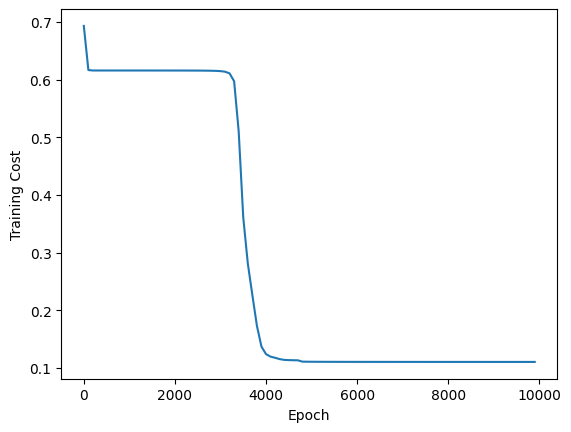

In [55]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 10000, 100), costs)
plt.xlabel('Epoch')
plt.ylabel("Training Cost")

# Testing the OOP Module

In [1]:
import numpy as np
from numpy_neural_net import NeuralNet

In [2]:
X = np.random.randn(100, 1000) 
Y = (np.sin( X[0, :] + X[6, :] ) > 0.5).astype(int).reshape(1, 1000)
layer_dims = [X.shape[0], 5, 3, 2, Y.shape[0]]

In [3]:
test_net = NeuralNet(X, Y, layer_dims, 'binary classification')

In [4]:
test_net.train_neural_network(training_epochs=10000, learning_rate=0.1)

Epoch 0 cost: 0.6931355062763359
Epoch 100 cost: 0.6325823398672523
Epoch 200 cost: 0.632030193654565
Epoch 300 cost: 0.6320230100892186
Epoch 400 cost: 0.6320218902671189
Epoch 500 cost: 0.632020794668924
Epoch 600 cost: 0.6320196602961915
Epoch 700 cost: 0.6320184146631791
Epoch 800 cost: 0.6320170640157968
Epoch 900 cost: 0.6320155946797685
Epoch 1000 cost: 0.6320138891072173
Epoch 1100 cost: 0.6320120346333278
Epoch 1200 cost: 0.6320099137191142
Epoch 1300 cost: 0.6320070112627209
Epoch 1400 cost: 0.6320038915598798
Epoch 1500 cost: 0.6320003007260011
Epoch 1600 cost: 0.6319961329790341
Epoch 1700 cost: 0.6319912038294299
Epoch 1800 cost: 0.6319853363124628
Epoch 1900 cost: 0.6319784299554688
Epoch 2000 cost: 0.6319702206943403
Epoch 2100 cost: 0.6319608834148028
Epoch 2200 cost: 0.631949677489395
Epoch 2300 cost: 0.6319358034968031
Epoch 2400 cost: 0.6319183686364509
Epoch 2500 cost: 0.631895907567038
Epoch 2600 cost: 0.6318660931827791
Epoch 2700 cost: 0.6318266543371277
Epoch 28

Text(0, 0.5, 'Training Cost')

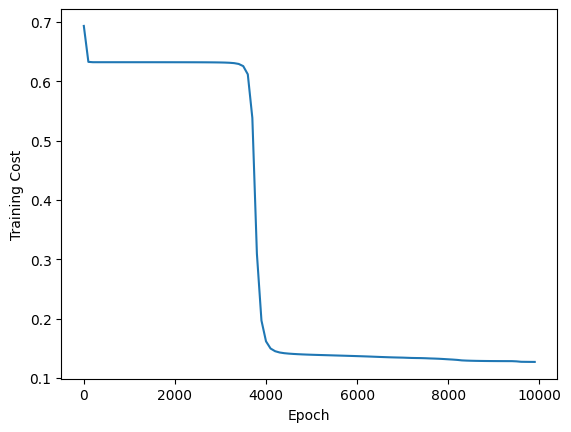

In [5]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, test_net.training_epochs, 100), test_net.training_costs)
plt.xlabel('Epoch')
plt.ylabel("Training Cost")

In [6]:
predictions = test_net.predict(X_test=X)

In [7]:
predictions.shape

(1, 1000)

In [13]:
X[:, 0]

array([ 0.79896048, -0.22905906,  1.80208115,  1.51319189, -0.3806771 ,
       -0.88878682,  0.75865578,  1.57519536,  0.49799349,  0.29027087,
       -0.71615854, -0.03062098,  0.70455003,  1.68037592, -2.17143898,
       -0.35873942,  1.43535711, -1.04714042, -0.20990418, -0.49002212,
        0.45147532, -0.10099671,  0.03340837, -0.9141321 ,  1.47407921,
       -0.10150343,  0.33349202, -0.27168553, -0.22711243, -0.82642627,
        0.59024313,  0.6750198 , -1.22543256,  0.09285193,  1.12841251,
        1.56874586, -1.13570058,  0.18072489, -0.56454989,  1.32798973,
       -0.94440198,  0.35518911, -0.22681478,  0.93220772, -0.5386848 ,
        1.11373103, -1.17233122, -0.92310782,  0.86554891, -1.08024277,
       -0.59201078, -1.18514667, -0.3132526 , -1.43197964,  0.67389359,
        1.44996656, -0.2101569 , -0.88983981,  0.82816746, -0.00599465,
        1.89798911, -0.14423211, -1.94358595,  0.40647668,  0.3710965 ,
       -0.43693569, -1.47665806, -1.13114531, -0.06040371, -0.21

In [10]:
# Single test example
test_net.predict(X[:, 0:3])

array([[1, 0, 0]])